### Import required modules

In [28]:
%matplotlib widget
import os
import csv
import json
import pickle
from time import sleep
import numpy as np
import pydicom as dcm
import nibabel as nib
from itkwidgets import view
from skimage import measure
from skimage import segmentation
import matplotlib.pyplot as plt

### Functions for loading cases, images, and masks

In [2]:
def get_metadata(filename):
    cases = {}
    with(open(filename, 'r') as csvf):
        csv_reader = csv.reader(csvf)
        header = next(csv_reader)
        for row in csv_reader:
            if not row[4].startswith("MED"):
                continue
            cases[row[4]] = {header[i]:row[i] for i in range(len(row))}
    return cases

def read_dicom(case: dict):
    filename = "Dataset" + case['File Location'][1:].replace('\\', '/')
    dcms = os.listdir(filename)
    dcms.sort()
    first_image = dcm.read_file(f"{filename}/{dcms[0]}")
    first_pixs = first_image.pixel_array
    volume = np.empty((first_pixs.shape[0], first_pixs.shape[1], len(dcms)))
    for idx, im in enumerate(dcms):
        pixels = dcm.read_file(f"{filename}/{im}").pixel_array
        volume[:,:,idx] = pixels.transpose()
    return volume

def read_mask(case: dict):
    case_name = case['File Location'][1:].split('\\')[2]
    filename = "Dataset/MED_ABD_LYMPH_MASKS/" + case_name + "/" + case_name + "_mask.nii.gz"
    mask = nib.load(filename).get_fdata()
    return mask

### Functions for performing processing on images and masks

In [3]:
def man_binary_thresh(arr, lo, hi):
    thresh = np.where((arr >= lo) & (arr <= hi), 1, 0)
    return thresh

def connected_components_2d(area, lo, hi, return_num=False):
    thresh = man_binary_thresh(area, lo, hi)
    comps, num = measure.label(thresh, return_num=True)
    return comps, num if return_num else comps

def sort_conn_comps(conn_comps, num_conn_comps):
    counts = [(idx, np.count_nonzero(conn_comps==idx)) for idx in range(num_conn_comps)]
    return sorted(counts, key = lambda i: i[1], reverse=True)
        
def find_average_pos(bin_image):
    x, y, z = np.nonzero(bin_image)
    return (np.mean(x), np.mean(y), np.mean(z))

def find_lungs(vol):
    # Binary threshold image
    bin_im = man_binary_thresh(vol, -900, -700)
    # Calculate average position (assumes this will be in a slice containing lung)
    average_pos = find_average_pos(bin_im)
    # Find connected components of the average position slice
    conn_comps, num_comps = connected_components_2d(np.squeeze(vol[:,:,int(average_pos[2])]), -900, -700, return_num=True)
    # Find the second biggest label which should correspond to lung
    lung_label = sort_conn_comps(conn_comps, num_comps)[1][0]
    flood_seed = list(zip(*np.nonzero(conn_comps==lung_label)))[0]
    # Flood fill volume using this label
    flood = segmentation.flood(bin_im, (*flood_seed, int(average_pos[2])))
    # Return corresponding elements in original volume
    lungs_vol = np.where(flood, vol, 0)
    return lungs_vol, (*flood_seed, int(average_pos[2]))

def find_nonzero_extent(arr, lungs=False, buffer_percent=0.0):
    inds = np.nonzero(arr)
    extent = [[int(min(inds[idx])), int(max(inds[idx]))] for idx in range(3)]
    if lungs:
        if abs(extent[0][0] - arr.shape[0]//2) < arr.shape[0]//8\
        and abs(extent[0][1] - arr.shape[0]//2) < arr.shape[0]//8:
            return extent # Do nothing, lungs weren't found
        elif abs(extent[0][0] - arr.shape[0]//2) < arr.shape[0]//8:
            extent[0][0] = int(arr.shape[0] - extent[0][1])
        elif abs(extent[0][1] - arr.shape[0]//2) < arr.shape[0]//8:
            extent[0][1] = int(arr.shape[0] - extent[0][0])
    if buffer_percent:
        for idx, pair in enumerate(extent):
            span = pair[1] - pair[0]
            extent[idx] = [max(int(pair[0]-buffer_percent*span/100.0), 0),
                           min(int(pair[1]+buffer_percent*span/100.0), arr.shape[idx])]
    return extent

### Load cases

In [5]:
cases = get_metadata('Dataset/metadata.csv')
cases_list = list(cases.keys())

### Visualize steps

In [8]:
test_vol = read_dicom(cases[cases_list[2]])
view(test_vol)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

In [9]:
bin_vol = man_binary_thresh(test_vol, -900, -700)
view(bin_vol)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageF3; pro…

In [12]:
avg_pos = find_average_pos(bin_vol[:,:,bin_vol.shape[2]//2:])
print(avg_pos)
print(avg_pos[2] + bin_vol.shape[2]//2)

(253.91429625370347, 259.25065426387596, 210.04975762619077)
588.0497576261907


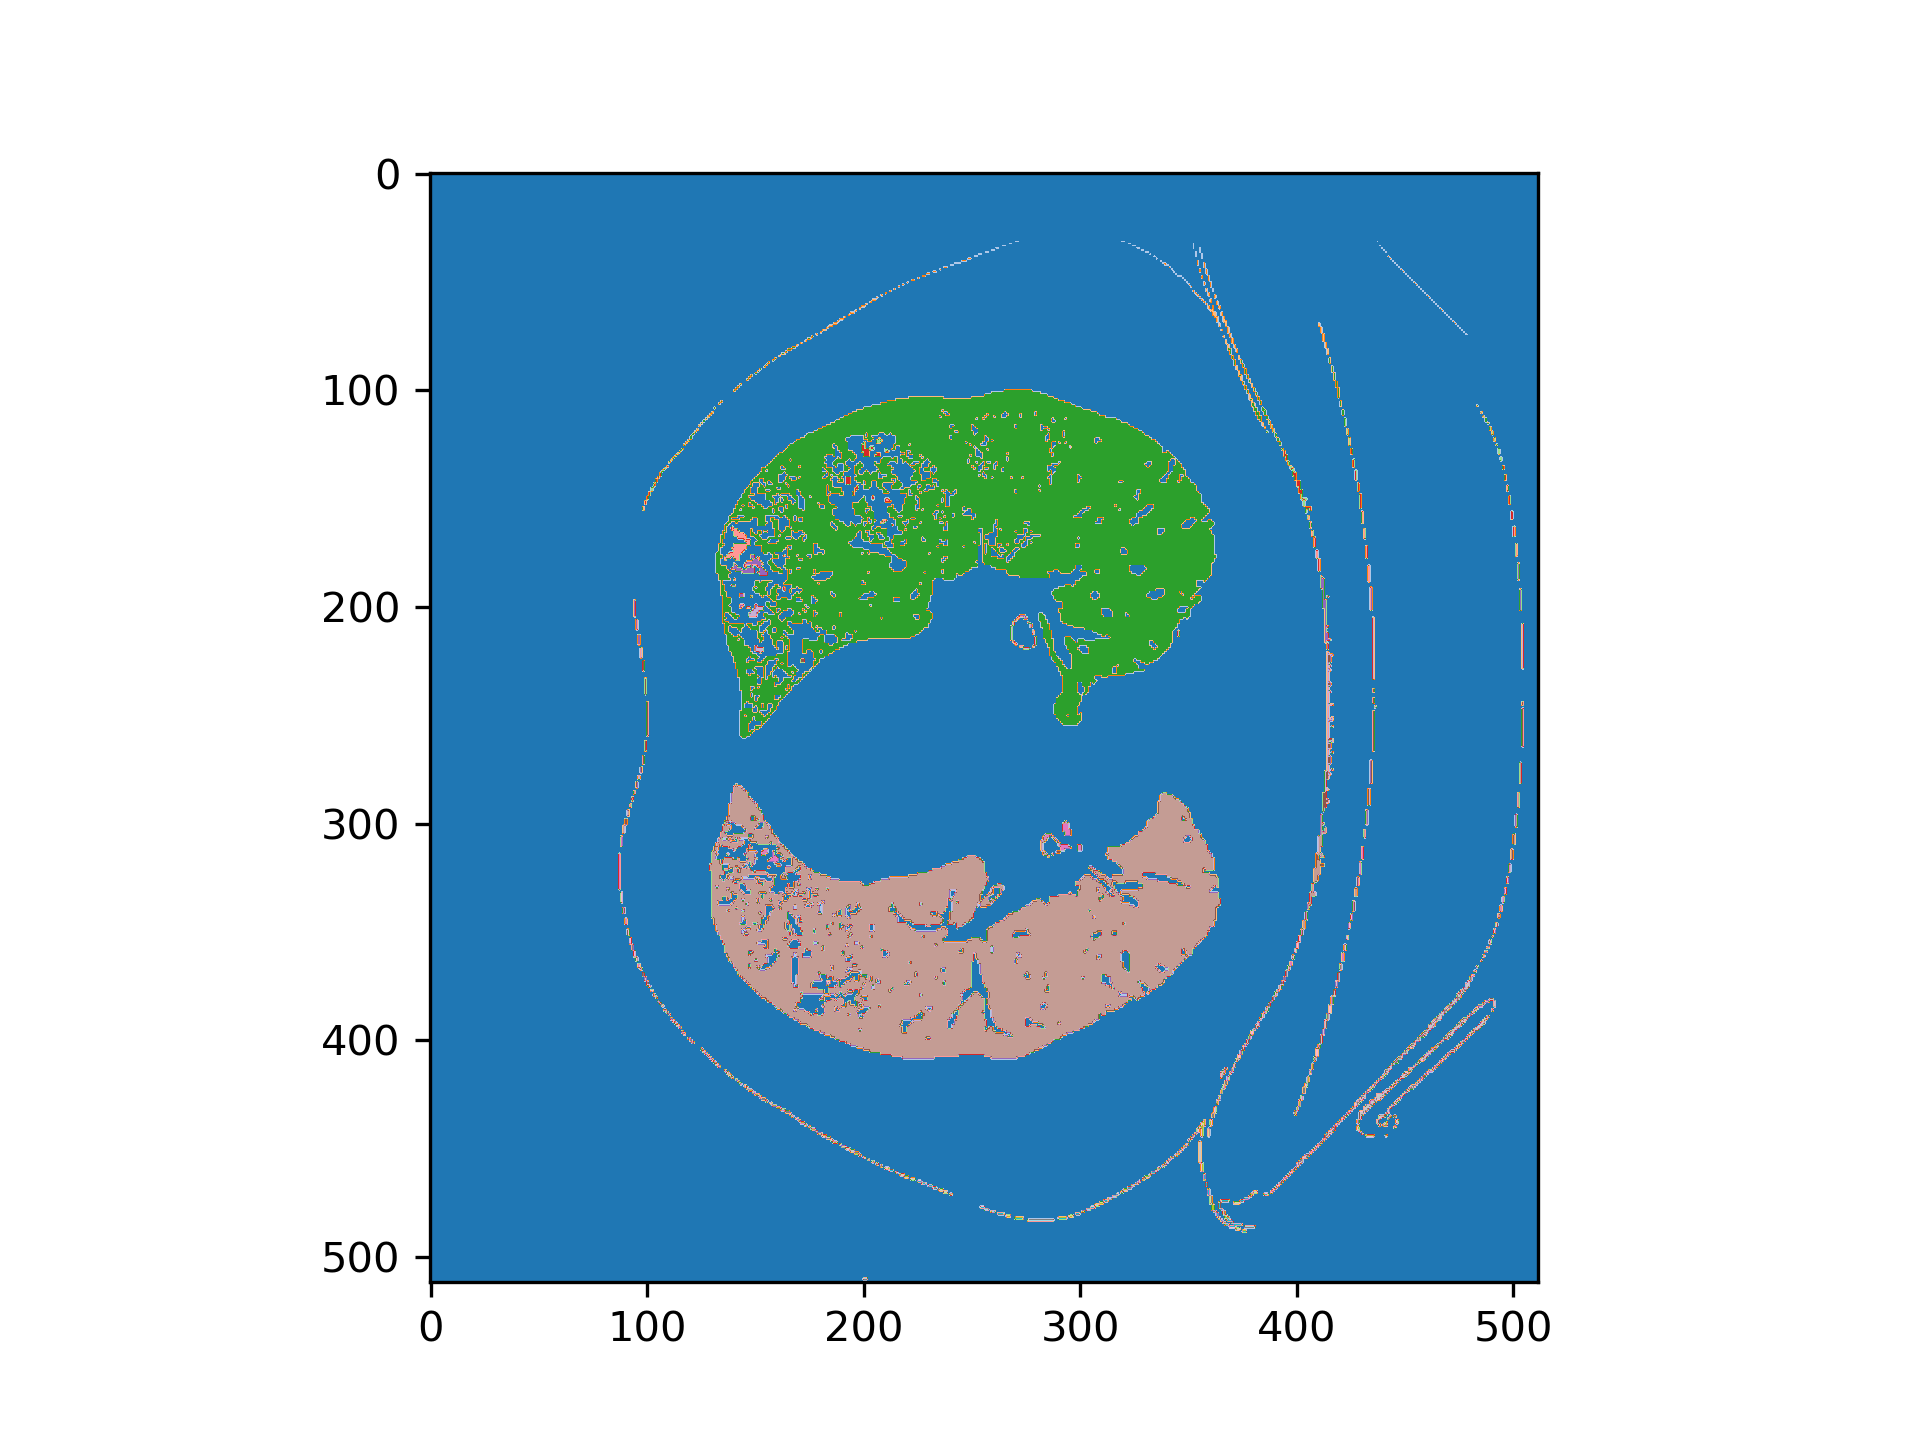

In [29]:
conn_comps, num_comps = connected_components_2d(test_vol[:, :, 588], -900, -700, return_num=True)
plt.figure(dpi=300)
plt.imshow(conn_comps, cmap='tab20')
plt.show()

In [42]:
lung_label = sort_conn_comps(conn_comps, num_comps)[1][0]
flood_seed = list(zip(*np.nonzero(conn_comps==lung_label)))[0]
# Flood fill volume using this label
flood = segmentation.flood(bin_vol, (*flood_seed, int(avg_pos[2]) + bin_vol.shape[2]//2))

In [40]:
flood = segmentation.flood(bin_vol[:,:,588], flood_seed)

In [46]:
lungs_only = np.zeros(flood.shape)
lungs_only[flood] = 1
view(lungs_only)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageD3; pro…

### See if bounding prism containing lungs includes masked lymph nodes

In [5]:
def test_prisms(cases, names=[]):
    failures, extents = {}, {}
    if not names:
        for idx, case in enumerate(cases.values()):
            vol = read_dicom(case)
            mask = read_mask(case)
            lungs, pos = find_lungs(vol[:,:,vol.shape[2]//2:])
            lungs_ext = find_nonzero_extent(lungs, lungs=True, buffer_percent=10.0)
            mask_ext = find_nonzero_extent(mask[:,:,mask.shape[2]//2:])
            for pair in zip(lungs_ext, mask_ext):
                if pair[1][1] > pair[0][1] or pair[1][0] < pair[0][0]:
                    print(f"\nFAIL WITH CASE {idx}")
                    failures[case["Subject ID"]] = {"lungs": lungs_ext, "mask": mask_ext}
                    break
            extents[case["Subject ID"]] = {"lungs": lungs_ext, "mask": mask_ext}

            print(f"Done with {idx} of {len(cases)-1}", end="\r")
            sleep(0) # This makes carriage return work. I dunno either.
    else:
        for name in names:
            vol = read_dicom(cases[name])
            mask = read_mask(cases[name])
            lungs, pos = find_lungs(vol[:,:,vol.shape[2]//2:])
            lungs_ext = find_nonzero_extent(lungs, lungs=True, buffer_percent=10.0)
            mask_ext = find_nonzero_extent(mask[:,:,mask.shape[2]//2:])
            for pair in zip(lungs_ext, mask_ext):
                if pair[1][1] > pair[0][1] or pair[1][0] < pair[0][0]:
                    print(f"\nFAIL WITH CASE {idx}")
                    failures[name] = {"lungs": lungs_ext, "mask": mask_ext}
                    break
            extents[name] = {"lungs": lungs_ext, "mask": mask_ext}
    return failures, extents

In [6]:
failures, extents = test_prisms(cases)

### Write failures and extents to file for later evaluation

In [7]:
with(open('lung_failures.json', 'w') as f):
    f.write(json.dumps(failures, indent=4))

with(open('bounding_prisms_extents.json', 'w') as f):
    f.write(json.dumps(extents, indent=4))


In [ ]:
with(open('lung_failures.json', 'r') as f):
    read_failures = json.loads(f.read())

In [9]:
with(open('bounding_prisms_extents.json', 'r') as f):
    read_extents = json.loads(f.read())

### View a fiew examples

In [10]:
def overlay_prism_on_vol(case):
    vol = read_dicom(cases[case])
    ext = read_extents[case]['lungs']
    prism = np.zeros_like(vol)
    prism[ext[0][0]:ext[0][1],
          ext[1][0]:ext[1][1],
          ext[2][0]+vol.shape[2]//2:ext[2][1]+vol.shape[2]//2] = 1
    return vol, prism

def overlay_prism_on_mask(case):
    mask = read_mask(cases[case])
    ext = read_extents[case]['lungs']
    prism = np.zeros_like(mask)
    prism[ext[0][0]:ext[0][1],
          ext[1][0]:ext[1][1],
          ext[2][0]+mask.shape[2]//2:ext[2][1]+mask.shape[2]//2] = 1
    return mask, prism

### Find and save size and center of prisms

In [11]:
extents_and_shapes = {}
for case, extents in read_extents.items():
    case_shape = read_dicom(cases[case]).shape
    
    ce, se, ae = extents["lungs"]
    
    ae = [a + case_shape[2]//2 for a in ae]
    extents_and_shapes[case] = {}
    extents_and_shapes[case]["bp_extents"] = [ce, se, ae]
    extents_and_shapes[case]["bp_shapes"] = [ce[1]-ce[0], se[1]-se[0], ae[1]-ae[0]]
    extents_and_shapes[case]["vol_shape"] = case_shape

In [12]:
with open("extents_and_shapes.json", "w") as f:
    f.write(json.dumps(extents_and_shapes, indent=4))

In [13]:
with open("extents_and_shapes.json", "r") as f:
    read_extents_and_shapes = json.loads(f.read())

### Find the central locations of the minimum number of 128^3 cubes required to cover the prism

In [14]:
def get_cube_extents(case, cube_size=128):
    vol_shape = read_extents_and_shapes[case]["vol_shape"]
    bp_shape = read_extents_and_shapes[case]["bp_shapes"]
    bp_extents = read_extents_and_shapes[case]["bp_extents"]
    
    cube_extents = [[], [], []]
    for dim in range(3):
        # If room for > 2 squares, distribute evenly
        if bp_shape[dim] / cube_size > 2:
            if not bp_shape[dim] % cube_size:
                num_sqs = bp_shape[dim] // cube_size
            else:
                num_sqs = bp_shape[dim]//cube_size + 1
                
            cube_extents[dim].append([bp_extents[dim][0], bp_extents[dim][0] + cube_size])
            ext_centers_span = bp_shape[dim] - cube_size
            adj_centers_span = ext_centers_span / (num_sqs-1)
            for c in range(num_sqs - 2):
                cube_extents[dim].append([cube_extents[dim][0][0] + (c+1)*int(adj_centers_span) - cube_size//2,
                                          cube_extents[dim][0][1] + (c+1)*int(adj_centers_span) + cube_size//2])
            cube_extents[dim].append([bp_extents[dim][1] - cube_size, bp_extents[dim][1]])
        else: # Only 2 squares, minimize overlap
            cube_extents[dim].append([bp_extents[dim][0], bp_extents[dim][0] + cube_size])
            cube_extents[dim].append([bp_extents[dim][1] - cube_size, bp_extents[dim][1]])
    return cube_extents

In [19]:
cube_extents = {}
for case in cases.keys():
    case_cube_extents = get_cube_extents(case, cube_size=128)
    cube_extents[case] = [[c, s, a] for c in case_cube_extents[0]
                                    for s in case_cube_extents[1]
                                    for a in case_cube_extents[2]]

### Save all potentially useful data into a JSON file

In [20]:
all_data = {}
for case in cases.keys():
    all_data[case] = {}
    all_data[case]["bp_shape"] = read_extents_and_shapes[case]["bp_shapes"]
    all_data[case]["bp_extents"] = read_extents_and_shapes[case]["bp_extents"]
    all_data[case]["num_cubes"] = len(cube_extents[case])
    all_data[case]["cube_extents"] = cube_extents[case]

In [21]:
with open("bp_and_cubes_data_128.json", "w") as f:
    f.write(json.dumps(all_data, indent=4))